In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path


from EvEye.utils.cache.MemmapCacheStructedEvents import *
from EvEye.utils.visualization.visualization import *
from EvEye.utils.tonic.functional.ToFrameStack import to_frame_stack_numpy

In [17]:
events_base_path = Path(
    "/mnt/data2T/junyuan/eye-tracking/10000dataset/train/cached_data"
)
ellipses_base_path = Path(
    "/mnt/data2T/junyuan/eye-tracking/10000dataset/train/cached_ellipse"
)
sensor_size = (346, 260, 2)

In [18]:
events = load_cached_structed_events(events_base_path)
ellipses = load_cached_structed_ellipses(ellipses_base_path)

In [19]:
index = 31
event = events[index]
ellipse = ellipses[index]

In [20]:
event_frame = to_frame_stack_numpy(
    event, (346, 260, 2), 1, "causal_linear", event['t'][0], event['t'][-1]
)
event_frame_vis = visualize(event_frame)
event_ellipse_vis = event_frame_vis.copy()
ellipse_to_draw = convert_to_ellipse(ellipse[0])
draw_ellipse(event_ellipse_vis, ellipse_to_draw)

椭圆中心: (134.12, 146.63), 长轴: 45.71, 短轴: 32.53, 旋转角度: -65.64


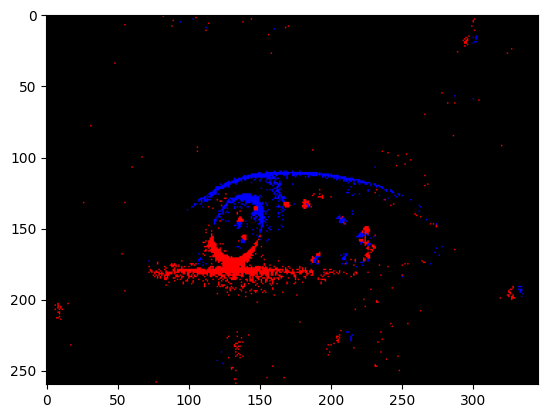

In [21]:
plt.imshow(event_frame_vis)

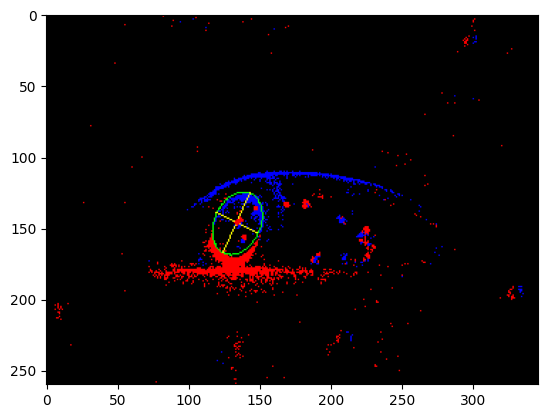

In [22]:
plt.imshow(event_ellipse_vis)

In [23]:
def detect_initial_ellipse(model, image):
    # 使用训练好的模型检测初始椭圆参数
    ellipse_params = model.predict(image)
    template_center = (ellipse_params[0], ellipse_params[1])
    return ellipse_params, template_center


def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))


def cal_average_distance(points, center):
    distances = [calculate_distance(p, center) for p in points]
    avg_distance = np.mean(distances)
    return avg_distance


def get_boundary_points(ellipse):
    """ellipse: tuple, (center, axes, angle)"""

    center = (int(ellipse[0][0]), int(ellipse[0][1]))
    axes = (int(ellipse[1][0] / 2), int(ellipse[1][1] / 2))
    angle = int(ellipse[2])
    startAngle = 0
    endAngle = 360
    delta = 1  # 角度步长，越小越精细

    boundary_points = cv2.ellipse2Poly(center, axes, angle, startAngle, endAngle, delta)
    boundary_points_list = boundary_points.tolist()
    return boundary_points_list


def get_image_points(image):
    """image: np.array, shape=(height, width, channels)"""

    points_array = np.argwhere(image)
    points_list = [[p[1], p[0]] for p in points_array]
    return points_list


def get_nearest_points(points, boundary_points):
    """找到距离模版的最近邻像素集合"""

    nearest_points = []
    for p in points:
        distances = [calculate_distance(p, bp) for bp in boundary_points]
        min_index = np.argmin(distances)
        nearest_points.append(boundary_points[min_index])
    return nearest_points


def find_nearest_boundary_point(point, boundary_points):
    distances = [calculate_distance(point, bp) for bp in boundary_points]
    min_index = np.argmin(distances)
    return boundary_points[min_index]


def get_candidate_points(points, center, avg_distance, lamda_1=0.8, lambda_2=1.2):
    candidate_points = [
        p
        for p in points
        if lamda_1 * avg_distance
        < calculate_distance(p, center)
        < lambda_2 * avg_distance
    ]
    return candidate_points


def select_candidate_points(events, avg_distance, c, lambda1=0.8, lambda2=1.2):
    return [
        e
        for e in events
        if lambda1 * avg_distance < calculate_distance(e, c) < lambda2 * avg_distance
    ]


def cal_average_displacement(nearest_points, candidate_points):
    delta_Tx = [q[0] - p[0] for p, q in zip(candidate_points, nearest_points)]
    delta_Ty = [q[1] - p[1] for p, q in zip(candidate_points, nearest_points)]
    avg_delta_Tx = np.mean(delta_Tx)
    avg_delta_Ty = np.mean(delta_Ty)
    return avg_delta_Tx, avg_delta_Ty


def compute_average_displacement(candidate_points, boundary_points):
    nearest_points = [
        find_nearest_boundary_point(p, boundary_points) for p in candidate_points
    ]
    delta_Tx = [q[0] - p[0] for p, q in zip(candidate_points, nearest_points)]
    delta_Ty = [q[1] - p[1] for p, q in zip(candidate_points, nearest_points)]
    avg_delta_Tx = np.mean(delta_Tx)
    avg_delta_Ty = np.mean(delta_Ty)
    return avg_delta_Tx, avg_delta_Ty


def update_candidate_points(candidate_points, avg_delta_Tx, avg_delta_Ty):
    return [(p[0] + avg_delta_Tx, p[1] + avg_delta_Ty) for p in candidate_points]


def update_ellipse_params(center, a, b, ang):
    return (center[0], center[1], a, b, ang)


def update_ellipse(model, image, events):
    ellipse_params, template_center = detect_initial_ellipse(model, image)

    x, y, a, b, ang = ellipse_params
    c = template_center
    boundary_points = get_boundary_points(x, y, a, b, ang)
    distances = [calculate_distance(p, c) for p in boundary_points]
    avg_distance = np.mean(distances)
    candidate_points = select_candidate_points(events, avg_distance, c)
    T = np.array([0, 0])

    for _ in range(100):
        avg_delta_Tx, avg_delta_Ty = compute_average_displacement(
            candidate_points, boundary_points
        )
        candidate_points = update_candidate_points(
            candidate_points, avg_delta_Tx, avg_delta_Ty
        )
        T += np.array([avg_delta_Tx, avg_delta_Ty])
        if np.linalg.norm([avg_delta_Tx, avg_delta_Ty]) / np.linalg.norm(T) < 0.01:
            break

    new_center = (c[0] - T[0], c[1] - T[1])
    new_ellipse_params = update_ellipse_params(new_center, a, b, ang)

    return new_ellipse_params

In [24]:
x, y = ellipse_to_draw[0][0], ellipse_to_draw[0][1]
a, b = ellipse_to_draw[1][0], ellipse_to_draw[1][1]
ang = ellipse_to_draw[2]
c = (x, y)

In [25]:
event_points_list = get_image_points(event_frame_vis)
boundary_points = get_boundary_points(ellipse_to_draw)
avg_distance = cal_average_distance(boundary_points, c)
print(avg_distance)
candidate_points = get_candidate_points(event_points_list, c, avg_distance)
nearest_points = get_nearest_points(candidate_points, boundary_points)
T = np.array([0, 0], dtype=np.float32)
while True:
    avg_delta_Tx, avg_delta_Ty = cal_average_displacement(
        nearest_points, candidate_points
    )
    candidate_points = update_candidate_points(
        candidate_points, avg_delta_Tx, avg_delta_Ty
    )
    T += np.array([avg_delta_Tx, avg_delta_Ty])
    print(T)
    if np.linalg.norm([avg_delta_Tx, avg_delta_Ty]) / np.linalg.norm(T) < 0.01:
        break
new_center = (c[0] - T[0], c[1] - T[1])
new_ellipse = ((new_center[0], new_center[1]), (a, b), ang)

18.880844425291958
[-0.10726643 -1.0934256 ]
[-0.10726643 -1.0934256 ]


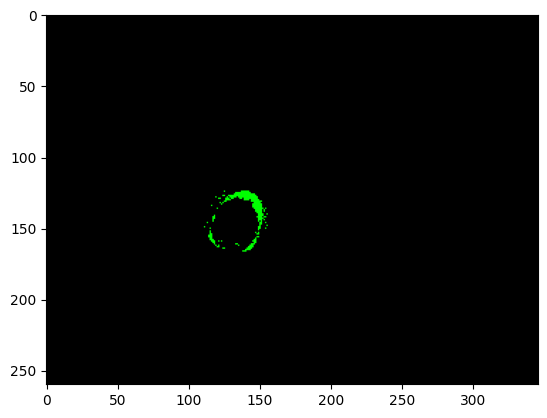

In [26]:
canvas_height = 260
canvas_width = 346
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
canvas_vis = draw_points(canvas, candidate_points)
plt.imshow(canvas_vis)

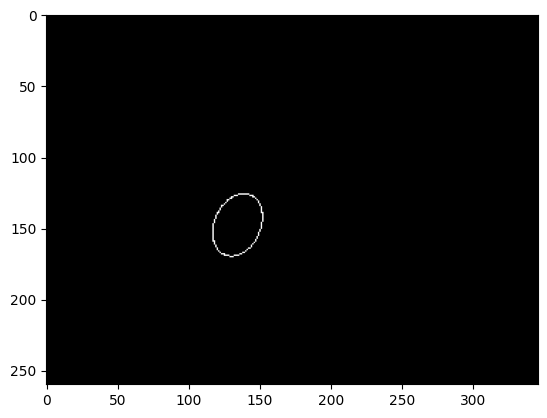

In [27]:
canvas_height = 260
canvas_width = 346
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
canvas_vis = cv2.ellipse(canvas, new_ellipse, (255, 255, 255), 1)
plt.imshow(canvas_vis)

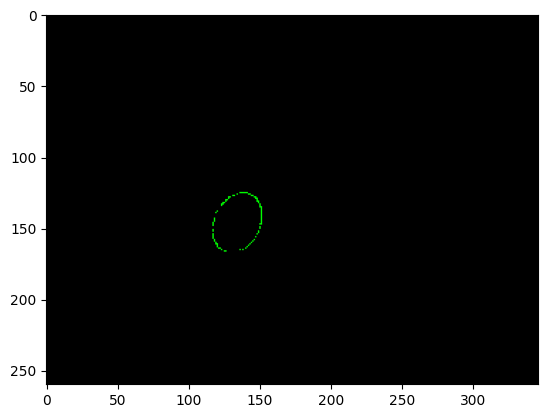

In [28]:
canvas_height = 260
canvas_width = 346
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
canvas_vis = draw_points(canvas, nearest_points)
plt.imshow(canvas_vis)

In [29]:
avg_distance

18.880844425291958

In [30]:
image_points = get_image_points(image)
image_height = 260
image_width = 346
image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
points_image = draw_points(image, image_points)
plt.imshow(points_image)

NameError: name 'image' is not defined

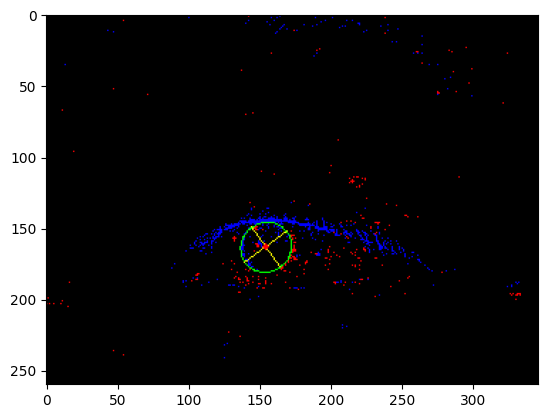

In [ ]:
plt.imshow(event_ellipse_vis)

In [ ]:
from EvEye.utils.PupilTracker import PupilTracker

pupil_tracker = PupilTracker()